In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from functools import partial
import math


x_min = -30
x_max = 25


delta_x = 0.2

batch_fun = lambda fun, *args, **kwargs: (lambda x: np.array([fun(xi, *args, **kwargs) for xi in x]))

x_base = []
y_base = []
current_x = x_min
while current_x <= x_max:
    x_base.append(current_x)
    y_base.append(current_x / (1 + math.exp(-current_x)))  # SiLU
    current_x += delta_x

In [2]:
def true_silu(x):
    return x * (1 / (1 + np.exp(-x)))


In [3]:
def piecewise_linear_silu(x, delta_x=0.1):
    # Create base points for interpolation
    x_base = np.arange(-30, 25 + delta_x, delta_x)
    y_base = true_silu(x_base)
    
    # Create interpolation function
    interp_func = interp1d(x_base, y_base, bounds_error=False, fill_value="extrapolate")
    
    return interp_func(x)


In [4]:
def spline_silu(x):

    # Create base points for interpolation
    x_base = np.arange(-30, 25 + 0.1, 0.2)
    y_base = true_silu(x_base)
    
    # Create interpolation function
    interp_func = interp1d(x_base, y_base, kind='cubic', bounds_error=False, fill_value="extrapolate")
    
    return interp_func(x)


In [5]:
def generate_silu_coefficients(x_min, x_max, step):
    # Generiere x-Werte
    x = np.arange(x_min, x_max + step, step)
    
    # Berechne echte SiLU-Werte
    y = true_silu(x)
    
    # Erstelle cubic spline
    cs = CubicSpline(x, y)
    
    # Hole Koeffizienten für jedes Intervall
    coefficients = []
    for i in range(len(x)-1):
        coef = cs.c[:, i]
        coefficients.append(coef)
    
    # Konvertiere zu Array für einfachere Handhabung
    coefficients = np.array(coefficients)
    
    return coefficients, x

coeffs, x_points = generate_silu_coefficients(x_min, x_max, delta_x)

In [6]:
def fast_silu_approx(x, coeffs=coeffs, x_min=x_min, step=delta_x):
    if x<-12:
        return 0
    if x>10:
        return x
    idx = int((x - x_min) / step)
    # idx = max(0, min(idx, len(coeffs)-1))  # Bound checking
    
    # Relative Position im Intervall
    x_local = x - (x_min + idx * step)
    
    # Polynomial auswerten
    return coeffs[idx][3] + coeffs[idx][2] * x_local + \
           coeffs[idx][1] * x_local**2 + coeffs[idx][0] * x_local**3

In [7]:
def generate_chebyshev_coeffs(degree, x_min=-12, x_max=10):
    """
    Berechnet Chebyshev-Approximation für SiLU
    
    Args:
        degree: Grad des Polynoms
        x_min, x_max: Intervallgrenzen
    Returns:
        coeffs: Koeffizienten für normales Polynom
    """
    # Chebyshev Knoten
    n = degree + 1
    k = np.arange(n)
    chebyshev_nodes = np.cos((2*k + 1)*np.pi/(2*n))
    
    # Transformation auf [x_min, x_max]
    x = 0.5 * (x_max - x_min) * chebyshev_nodes + 0.5 * (x_max + x_min)
    
    # Funktionswerte an den Knoten
    f = true_silu(x)
    
    # Berechne Chebyshev-Koeffizienten
    c = np.polynomial.chebyshev.Chebyshev.fit(x, f, degree)
    
    # Konvertiere zu normalen Polynomial-Koeffizienten
    coeffs = np.polynomial.chebyshev.cheb2poly(c)
    
    return coeffs

In [8]:
generate_chebyshev_coeffs(2)[0]

Chebyshev([1.99660619, 4.26243614, 2.26554761], domain=[-10.52627944,   8.52627944], window=[-1.,  1.], symbol='x')

In [9]:
def generate_minimax_coeffs(degree, x_min=-12, x_max=10, num_points=10000):
    """
    Berechnet Minimax-Approximation für SiLU
    Verwendet Remez-Algorithmus (hier vereinfacht durch polyfit)
    
    Args:
        degree: Grad des Polynoms
        x_min, x_max: Intervallgrenzen
        num_points: Anzahl der Stützstellen
    Returns:
        coeffs: Koeffizienten für normales Polynom
    """
    x = np.linspace(x_min, x_max, num_points)
    y = true_silu(x)
    
    # Verwende polyfit als Approximation für Minimax
    coeffs = np.polyfit(x, y, degree)
    
    return coeffs[::]  # Umkehren für aufsteigende Potenz

In [10]:
def eval_polynomial(x, coeffs):
    """
    Wertet Polynom mittels Horner-Schema aus
    
    Args:
        x: Eingabewert oder Array
        coeffs: Koeffizienten (aufsteigend)
    Returns:
        y: Approximierter Wert
    """
    result = coeffs[0]
    for c in coeffs[1:]:
        result = result * x + c
    return result

In [11]:
def evaluate_approximation(approx_func, dense_points=1000000, sparse_points=20000, epsilon=1e-3):
    # Create evaluation points
    # Dense region from -2.6 to 2.1
    x_dense = np.linspace(-2.6, 2.1, dense_points)
    
    # Sparse regions
    x_sparse_left = np.linspace(x_min, -2.6, sparse_points, endpoint=False)
    x_sparse_right = np.linspace(2.1, x_max, sparse_points)
    
    # Combine all points
    x_eval = np.concatenate([x_sparse_left, x_dense, x_sparse_right])
    
    # Calculate true and approximate values
    y_true = true_silu(x_eval)
    y_approx = approx_func(x_eval)
    
    # Initialize error array
    error = np.zeros_like(y_true)
    
    # Compute masks
    large_mask = np.abs(y_true) > epsilon
    small_mask = ~large_mask
    
    # Compute relative error where y_true is large
    error[large_mask] = np.abs((y_approx[large_mask] - y_true[large_mask]) / y_true[large_mask])
    
    # Compute absolute error where y_true is small
    error[small_mask] = np.abs(y_approx[small_mask] - y_true[small_mask])
    
    # Define acceptable errors
    max_relative_error = 1e-4
    max_absolute_error = epsilon * 1e-1 # Adjust as necessary
    
    # Check if approximation meets error requirements
    dense_mask = (x_eval >= -2.6) & (x_eval <= 2.1)
    sparse_mask = ~dense_mask
    
    # For dense region
    dense_large = dense_mask & large_mask
    dense_small = dense_mask & small_mask
    
    dense_pass = (np.all(error[dense_large] < max_relative_error) and
                  np.all(error[dense_small] < max_absolute_error))
    
    # For sparse region
    sparse_large = sparse_mask & large_mask
    sparse_small = sparse_mask & small_mask
    
    sparse_pass = (np.all(error[sparse_large] < max_relative_error) and
                   np.all(error[sparse_small] < max_absolute_error))
    
    return x_eval, error, dense_pass and sparse_pass

In [12]:
def plot_errors(approximations):

    # plot functions
    plt.figure(figsize=(12, 6))
    x = np.linspace(x_min, x_max, 1000)
    y_true = true_silu(x)
    plt.plot(x, y_true, label="Silu")
    for func, name in approximations:
        plt.plot(x, func(x), label=f'{name}')
    plt.ylim(y_true.min(), y_true.max())
    plt.legend()
    plt.show()

    # Plot results for each approximation
    plt.figure(figsize=(12, 6))

    for func, name in approximations:
        x_eval, rel_error, passes = evaluate_approximation(func)
        plt.semilogy(x_eval, rel_error, label=f'{name}')
        print(f"{name}: {'PASS' if passes else 'FAIL'}")
        
    # Plot error requirements
    plt.plot([-2.6, -2.6], [1e-3, 1e-4], color='red', linestyle=':', alpha=0.3, linewidth=3)
    plt.plot([2.1, 2.1], [1e-3, 1e-4], color='red', linestyle=':', alpha=0.3, linewidth=3)
    plt.plot([-2.6, 2.1], [1e-4, 1e-4], color='red', linestyle=':', alpha=0.7, linewidth=3, label='Dense region target (1e-4)')
    plt.plot([x_min, -2.6], [1e-3, 1e-3], color='red', linestyle=':', alpha=0.7, linewidth=3, label='Sparse region target (1e-3)')
    plt.plot([2.1, x_max], [1e-3, 1e-3], color='red', linestyle=':', alpha=0.7, linewidth=3)
    
    plt.grid(True)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Relative Error')
    plt.title('Relative Error of SiLU Approximations')
    plt.ylim(1e-6, 1e-1)
    
    plt.show()
    
    # Plot dense region only
    plt.figure(figsize=(12, 6))
    
    for func, name in approximations:
        x_eval, rel_error, passes = evaluate_approximation(func)
        dense_mask = (x_eval >= -2.6) & (x_eval <= 2.1)
        plt.semilogy(x_eval[dense_mask], rel_error[dense_mask], label=f'{name}')
    
    plt.plot([-2.6, 2.1], [1e-4, 1e-4], color='red', linestyle=':', alpha=0.7, linewidth=3, label='Dense region target (1e-4)')
    
    plt.grid(True)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Relative Error')
    plt.title('Relative Error of SiLU Approximations (Dense Region)')
    plt.ylim(1e-6, 1e-1)
    
    plt.show()


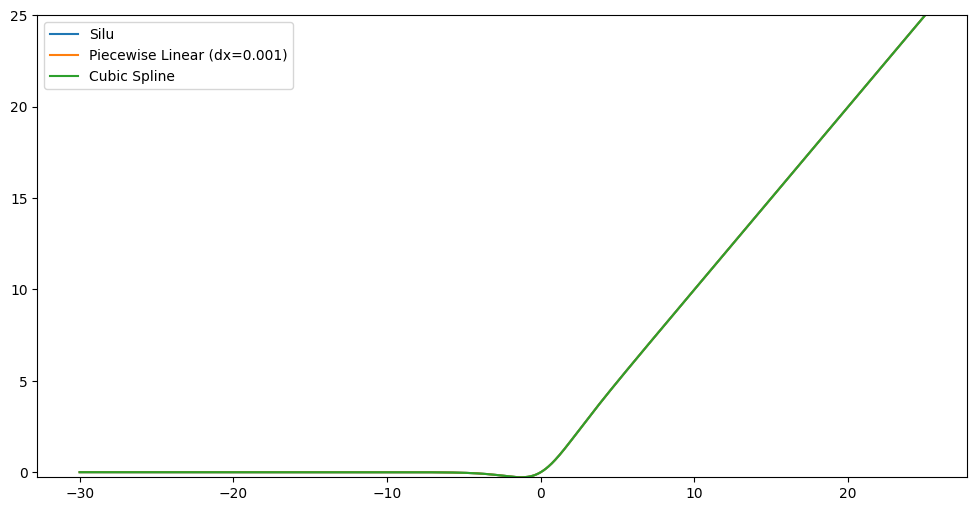

Piecewise Linear (dx=0.001): PASS
Cubic Spline: PASS


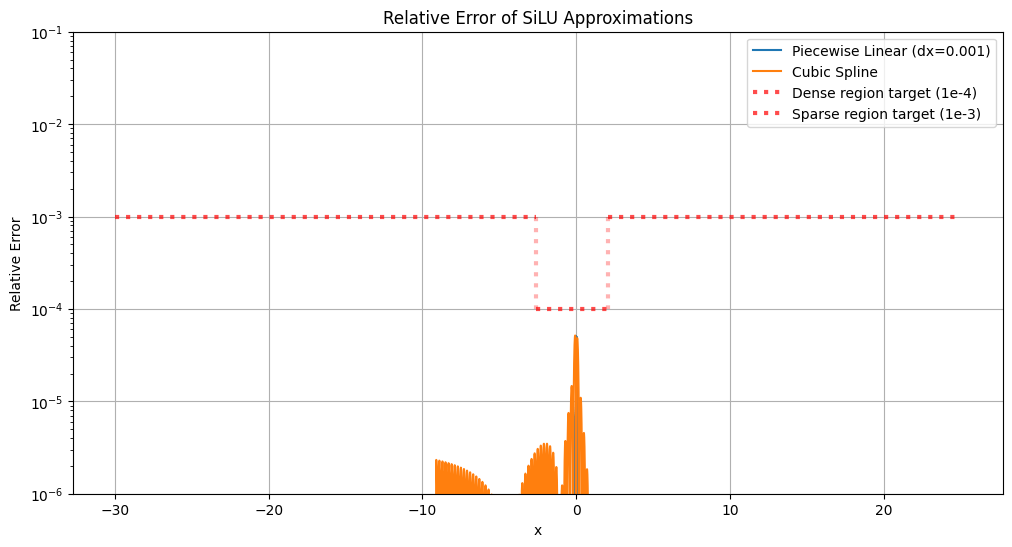

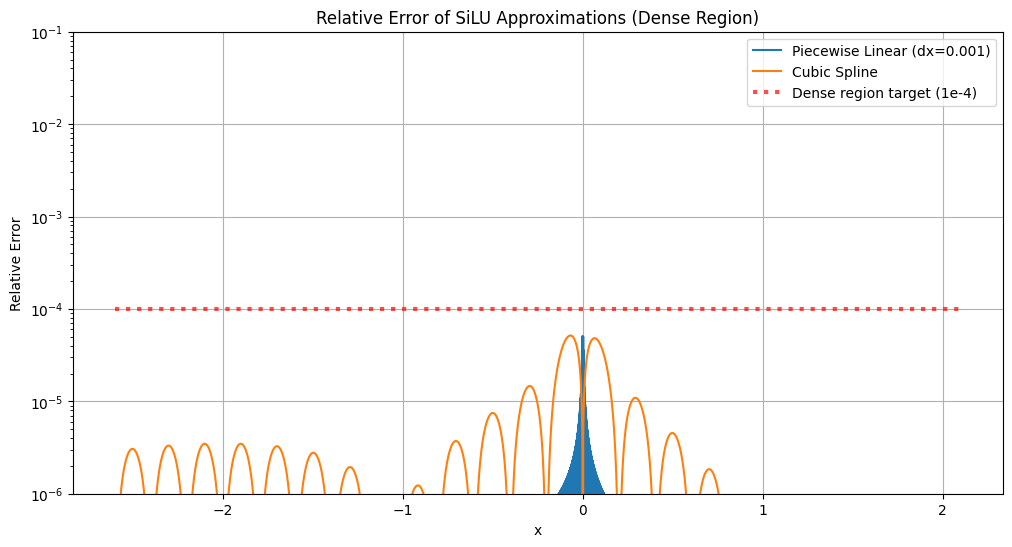

In [18]:
chebyshev_coefs = generate_chebyshev_coeffs(2)
# minimax_coefs = generate_minimax_coeffs(30)

# Define approximations to test
approximations = [
    (lambda x: piecewise_linear_silu(x, 0.001), 'Piecewise Linear (dx=0.001)'),
    (lambda x: spline_silu(x), 'Cubic Spline'),
    # (lambda x: batch_fun(fast_silu_approx)(x), 'Fast Cubic Spline'),
    # (lambda x: batch_fun(eval_polynomial, chebyshev_coefs)(x), 'Chebychev'),
    # (lambda x: batch_fun(eval_polynomial, minimax_coefs)(x), 'Minimax'),
]

# Run evaluation and create plot
plot_errors(approximations)